In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TensorFlow and Keras for model building and training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Giuse\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load all sheets from the Excel file
#all_sheets_data= pd.read_excel("C:\\Bayes Business School\\Applied Deep Learning\\Datasets//online_retail_II.xlsx", sheet_name=None)

In [3]:
# Concatenate the data from both sheets into one DataFrame
combined_data = pd.concat(all_sheets_data.values())

# Reset the index of the combined DataFrame to ensure it's unique and sequential
combined_data.reset_index(drop=True, inplace=True)

In [4]:
# Checking for missing values in each column
missing_values = combined_data.isnull().sum()
missing_values_percentage = (combined_data.isnull().sum() / len(combined_data)) * 100

missing_data_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_values_percentage
})

In [5]:
# Remove rows where 'Customer ID' is missing because we can't track customer behavior without it
data_clean = combined_data.dropna(subset=['Customer ID'])

In [6]:
# Check the shape of the data after removal
cleaned_data_shape = data_clean.shape

# Summary of the cleaned data to confirm removal of missing values
cleaned_missing_summary = data_clean.isnull().sum()

cleaned_data_shape, cleaned_missing_summary

((824364, 8),
 Invoice        0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 Price          0
 Customer ID    0
 Country        0
 dtype: int64)

In [7]:
# Identify and remove rows with negative or zero quantities
positive_quantity_data = data_clean[data_clean['Quantity'] > 0].copy()

# Summary of the data after removing negative or zero quantities
positive_data_summary = {
    "Original Rows": cleaned_data_shape[0],
    "Rows After Removal": positive_quantity_data.shape[0],
    "Rows Removed": cleaned_data_shape[0] - positive_quantity_data.shape[0]
}

In [8]:
# Convert InvoiceDate to datetime and extract year and month
positive_quantity_data['YearMonth'] = positive_quantity_data['InvoiceDate'].dt.to_period('M')

# Aggregate purchase amounts by customer and year-month
monthly_purchases = positive_quantity_data.groupby(['Customer ID', 'YearMonth']).agg({'Price': 'sum'}).reset_index()

# Pivot the data
pivot_table = monthly_purchases.pivot(index='Customer ID', columns='YearMonth', values='Price').fillna(0)

# Calculate the 'score' - average number of months per annum with a purchase
pivot_table['Purchase_Frequency_Score'] = (pivot_table > 0).sum(axis=1) / 2  
pivot_table.head()

YearMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Purchase_Frequency_Score
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,19.0,18.0,0.0,27.05,0.00,0.0,142.31,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,2.5
12347.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,62.29,0.0,53.62,0.0,68.24,0.0,120.76,0.0,13.54,4.0
12348.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,14.39,...,44.60,0.0,0.00,0.0,0.00,42.5,0.00,0.0,0.00,2.5
12349.0,0.0,0.0,0.0,0.00,194.58,200.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,605.1,0.00,2.0
12350.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.5


In [9]:
# Step 1: Initialize labeled_data to include all columns from cleaned_data
risk_data = pd.DataFrame(index=pivot_table.index, columns=pivot_table.columns)

# Step 2: Set initial labels based on purchase activity for all months
for month in risk_data.columns[:-1]:  # Exclude 'score' for initial labeling
    risk_data[month] = np.where(pivot_table[month] > 0, 0, True)  # 0 for activity, True for no activity

# Step 3: Refine labels to identify churn risk for each month except the last two and 'score'
for column in range(len(pivot_table.columns) - 3):  # Exclude the last two months and 'score' from this process
    column_name = pivot_table.columns[column]
    next_column = pivot_table.columns[column + 1]
    next_column_2 = pivot_table.columns[column + 2]
    
    # Applying conditions for churn risk
    conditions = [
        risk_data[column_name] == True,  # No purchase in the current month
        (risk_data[next_column] == True) & (risk_data[next_column_2] == True)  # No purchases in the next two months
    ]
    choices = [0, 2]  # 0: Active, 2: High churn risk
    risk_data[column_name] = np.select(conditions, choices, default=1)  # 1: Low churn risk

# Step 4: Correctly label the last two months based on activity
last_two_months = pivot_table.columns[-3:-1]  # Selecting the last two months before 'score'
for month in last_two_months:
    risk_data[month] = np.where(pivot_table[month] > 0, 0, 1)  # 0 for activity, 1 for no activity

# Ensure 'score' is copied correctly without modification
risk_data["Purchase_Frequency_Score"] = pivot_table["Purchase_Frequency_Score"]

risk_data.head()

YearMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Purchase_Frequency_Score
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,1,1,0,2,0,0,2,0,0,0,...,0,0,0,0,0,0,0,1,1,2.5
12347.0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,1,0,4.0
12348.0,0,0,0,0,0,0,0,0,0,2,...,2,0,0,0,0,2,0,1,1,2.5
12349.0,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.5


array([[<Axes: title={'center': 'Purchase_Frequency_Score'}>]],
      dtype=object)

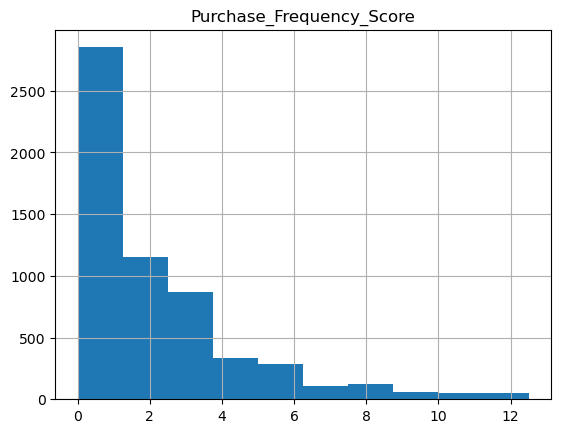

In [10]:
# Plot Purchase_Frequency_Score distribution
pivot_table.hist(column="Purchase_Frequency_Score")

In [11]:
# Assuming top customers are those with the highest scores
# Let's select the top quartile
score_threshold = pivot_table['Purchase_Frequency_Score'].quantile(0.75)
top_customers = pivot_table[pivot_table['Purchase_Frequency_Score'] >= score_threshold]
top_customers_labels = risk_data.loc[top_customers.index]

# Prepare X and y using the scores (excluding the 'score' column itself for X)
X = top_customers.iloc[:, 1:-1].to_numpy()  # Exclude 'score' column and use up to the second last column
y = top_customers_labels.iloc[:, 1:-1].to_numpy()  # Align with X's column selection

# Reshape for LSTM input
X = X[:, :, np.newaxis]
y = y[:, :, np.newaxis]

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=12)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.2, random_state=15)

X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1041, 24, 1),
 (90, 24, 1),
 (357, 24, 1),
 (357, 24, 1),
 (90, 24, 1),
 (90, 24, 1))

In [13]:
# Define an Adam optimizer with a learning rate of 0.001 
optimizer = Adam(learning_rate=0.001)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=20,return_sequences=True),
    tf.keras.layers.LSTM(units=20,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

# Compile the model
model.compile(optimizer= optimizer, loss='mse',  metrics=['mae'])

# Setup callbacks for early stopping and model checkpointing
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_best_tf_modelRNN.keras", save_best_only=True)

# Print the model summary to check the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 20)         │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │            21 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
log = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_valid, y_valid),callbacks=[early_stopping_cb, checkpoint_cb], verbose=1)

Epoch 1/1000


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.4760 - mae: 0.5291 - val_loss: 0.3664 - val_mae: 0.4807
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3423 - mae: 0.4572 - val_loss: 0.2666 - val_mae: 0.3720
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2429 - mae: 0.3502 - val_loss: 0.2061 - val_mae: 0.2966
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1950 - mae: 0.2935 - val_loss: 0.1912 - val_mae: 0.2989
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1789 - mae: 0.2841 - val_loss: 0.1801 - val_mae: 0.2784
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1731 - mae: 0.2798 - val_loss: 0.1726 - val_mae: 0.2666
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1634 - mae: 0.2718 - val_loss: 0.1662 - val_mae: 0.2583
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1532 - mae: 0.2601 - val_loss: 0.1580 - val_mae: 0.2646
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1529 

In [15]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

# Prediction on the test set
test_predictions = model.predict(X_test)

# Reshape test_predictions and y_test to a suitable format for further evaluation analysys
test_predictions_reshaped = test_predictions.reshape((90, 24))
y_test_reshaped= y_test.reshape((90, 24))

# Calculate accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test_reshaped, test_predictions_reshaped))

# Print the accuracy metrics
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {rmse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0665 - mae: 0.1433 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
Test loss: 0.06385254114866257
Test MAE: 0.13837021589279175
Test RMSE: 0.2532387251339824


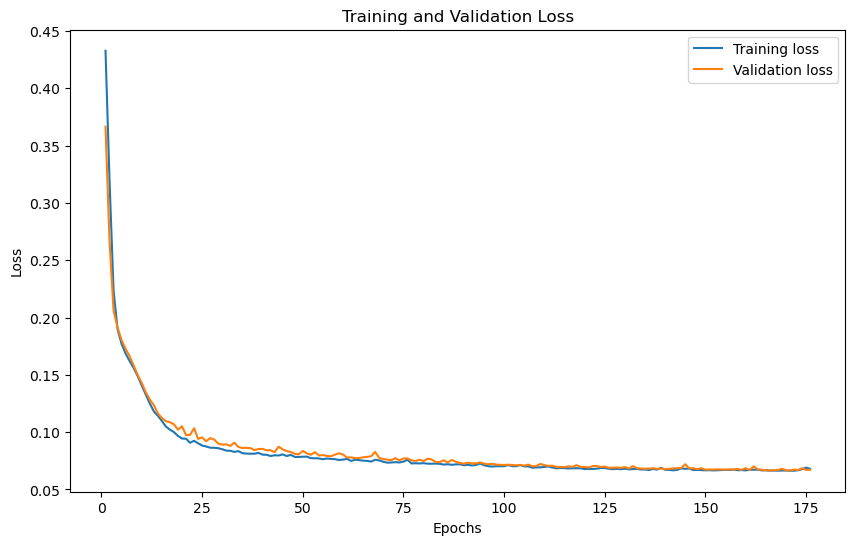

In [16]:
loss = log.history['loss']
val_loss = log.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training loss') 
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
print("MAE:", log.history['mae'][-1])
print("Validation MAE:", log.history['val_mae'][-1])
print("Indication of Variance (MAE difference):", abs(log.history['mae'][-1] - log.history['val_mae'][-1]))

MAE: 0.14625225961208344
Validation MAE: 0.14448563754558563
Indication of Variance (MAE difference): 0.0017666220664978027


In [18]:
# Select features from the top_customers DataFrame, excluding the first column (typically an ID or index) and the last column, and assign it to prediction_data
predictions = top_customers.iloc[:,1:-1]

# Convert the prediction_data DataFrame to a numpy array, ensuring a copy is made to avoid modifying the original data
prediction_data_numpy = predictions.to_numpy(copy=True)

# Add an additional dimension to the numpy array to match the input shape expected by LSTM models,
# which is [samples, time steps, features]. Since the data has a single feature per time step, we use np.newaxis to add the required third dimension
prediction_data_numpy = prediction_data_numpy[:,:,np.newaxis]

In [19]:
# Make predictions
predictions = model.predict(prediction_data_numpy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
print(predictions.shape)

(1488, 24, 1)


In [21]:
# Reshape the predictions array to a 2-dimensional format where the first dimension is the number of samples
# (in this case, 1488 samples) and the second dimension is the number of time steps (24 months).
# This is  done to match the original structure of the data before it was reshaped for model input
predictions_reshaped = predictions.reshape((1488, 24))

In [22]:
# Scaling the predictions
min_max_scaler = MinMaxScaler()
predictions_normalised = min_max_scaler.fit_transform(predictions_reshaped)
y_pred_normalised = predictions_normalised[:, -1]  # Focus on the last month

In [23]:
# Convert the y_pred_scaled numpy array into a pandas DataFrame with one column named "probability"
y_pred_dataset = pd.DataFrame(y_pred_normalised, columns=["Probability"])

In [24]:
# Add a "Customer ID" column to the DataFrame, assigning the index values from the top_customers DataFrame as customer IDs
y_pred_dataset["Customer ID"] = top_customers.index

In [25]:
# Create a new DataFrame final_probabilities by directly specifying its columns and data
# This is done by extracting the "Customer ID" and "probability" columns from the y_pred_dataframe and converting them back into numpy arrays
churn_risk_likelihood_dataset = pd.DataFrame(data={"Customer ID" : y_pred_dataset["Customer ID"].to_numpy(),"Probability": y_pred_dataset["Probability"].to_numpy()})

In [26]:
# Alternatively, merge to handle non-unique or missing IDs more gracefully
churn_risk_likelihood_dataset = churn_risk_likelihood_dataset.merge(positive_quantity_data[['Customer ID', 'Country']].drop_duplicates('Customer ID', keep='last'),
                                                on='Customer ID', 
                                                how='left')

In [27]:
churn_risk_likelihood_dataset

,Customer ID,Probability,Country
0,12347.0,0.087016,Iceland
1,12359.0,0.946649,Cyprus
2,12360.0,0.949141,Austria
3,12362.0,0.071746,Belgium
4,12380.0,0.940497,Belgium
...,...,...,...
1483,18259.0,0.914027,United Kingdom
1484,18260.0,0.915821,United Kingdom
1485,18272.0,0.085637,United Kingdom
1486,18276.0,0.922105,United Kingdom
